In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from tqdm import tqdm
import time
import matplotlib.pyplot as plt
import numpy as np

In [2]:
#图形变换transform
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean = (0.5, 0.5, 0.5), std = (0.5, 0.5, 0.5))
])

In [65]:
#引入数据
trainset = torchvision.datasets.CIFAR10(root='./data', download=True, transform = transform)
trainloader = torch.utils.data.DataLoader(trainset, shuffle=True, batch_size=16)
testset = torchvision.datasets.CIFAR10(root='./data', download=True, train=False, transform = transform)
testloader = torch.utils.data.DataLoader(testset, shuffle=False, batch_size=16)

Files already downloaded and verified
Files already downloaded and verified


In [66]:
data, label = next(iter(trainloader))
label

tensor([7, 7, 0, 4, 8, 0, 2, 7, 3, 8, 5, 3, 0, 7, 7, 4])

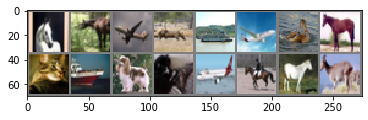

In [67]:
def imshow(img):
    #[channel, height, width]
    img = img / 2 + 0.5
    npimg = img.numpy()
    npimg = np.transpose(npimg, (1, 2, 0))
    plt.imshow(npimg)

photos = torchvision.utils.make_grid(data)
imshow(photos)

In [68]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
for i in label:
    print(classes[i]+' ',end='')

horse horse plane deer ship plane bird horse cat ship dog cat plane horse horse deer 

In [69]:
data[0].shape

torch.Size([3, 32, 32])

## 普通的卷积神经网络

In [70]:
class Net(nn.Module):
    def __init__(self, input_size = (3, 32, 32)):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=3, padding=1, stride=2)# 6x16x16
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=3, padding=1) # 16x16x16
        self.full1 = nn.Linear(16*16*16, 512)
        self.full2 = nn.Linear(512, 128)
        self.full3 = nn.Linear(128, 10) #输出10类预测概率
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self, x):
        x = self.relu(self.conv1(x))
        
        x = self.relu(self.conv2(x))
        
        x = x.view(-1, 16*16*16) #?
        x = self.relu(self.full1(x))
        
        x = self.relu(self.full2(x))
        
        x = self.full3(x)        
        return x

In [71]:
net = Net()
print(net)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (full1): Linear(in_features=4096, out_features=512, bias=True)
  (full2): Linear(in_features=512, out_features=128, bias=True)
  (full3): Linear(in_features=128, out_features=10, bias=True)
  (relu): ReLU(inplace=True)
)


In [72]:
from torch.optim import SGD

criterion = nn.CrossEntropyLoss()
optimizer = SGD(net.parameters(), momentum=0.9, lr=0.0001)#weight_decay=0.01 权重衰减 用于防止过拟合的

In [73]:
#使用早停法，如果在测试集上准确率五轮没有提升，就停止训练
train_loss = []
time1 = time.time()
max_acc = 0
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
improve_epoch = 0

for epoch in tqdm(range(10)):
    net.train()
    net.to(device)
    training_loss = 0
    if epoch - improve_epoch == 5:
        print("早停")
        break
    for i, data in enumerate(trainloader):
        img, label = data
        img, label = img.to(device), label.to(device)
        
        optimizer.zero_grad()
        output = net(img)
        loss = criterion(output, label)
        loss.backward() #梯度反向传播，生成梯度到优化器中
        optimizer.step() #优化器对梯度进行加减
        
        training_loss += loss.item()
        
        if((i+1) % 100 == 0):
            print(f'[{epoch+1} {i+1}] loss: {training_loss / 100}')
            training_loss = 0
            
        if((i+1) % 3125 == 0):
            net.eval()
            test_loss = 0
            accuracy = 0
            for j, data in enumerate(testloader): #625个
                imgs, labels = data
                outputs = net(imgs)
                loss = criterion(outputs, labels)
                test_loss += loss.item()
                
                correct = torch.sum((outputs.argmax(dim=1) == labels))
                total = len(labels)
                accuracy += correct / total

                if (j+1) % 125 == 0:
                    print(f'*** {j+1} test loss: {test_loss / 125}')                    
                    print(f'*** {j+1} test accuracy: {accuracy / 125}') #
                    if accuracy > max_acc:
                        max_acc = accuracy
                        improve_epoch = epoch
                        torch.save(net.state_dict(), './private_model/cifa10_best_state.pth')
                    test_loss = 0
                    accuracy = 0
                    
time2 = time.time()
print('花费时间：',time2-time1)






  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

[1 100] loss: 2.303106813430786
[1 200] loss: 2.3042881512641906
[1 300] loss: 2.302381007671356
[1 400] loss: 2.303058090209961
[1 500] loss: 2.3029101037979127
[1 600] loss: 2.3039816093444823
[1 700] loss: 2.3045147895812987
[1 800] loss: 2.301561677455902
[1 900] loss: 2.300673789978027
[1 1000] loss: 2.300567705631256
[1 1100] loss: 2.300404417514801
[1 1200] loss: 2.302372817993164
[1 1300] loss: 2.3016627717018125
[1 1400] loss: 2.2986078333854674
[1 1500] loss: 2.2999076414108277
[1 1600] loss: 2.3007084488868714
[1 1700] loss: 2.300771942138672
[1 1800] loss: 2.296352069377899
[1 1900] loss: 2.298312740325928
[1 2000] loss: 2.3001429057121277
[1 2100] loss: 2.2987287282943725
[1 2200] loss: 2.2954757237434387
[1 2300] loss: 2.295333693027496
[1 2400] loss: 2.2951024866104124
[1 2500] loss: 2.295746660232544
[1 2600] loss: 2.2956417274475096
[1 2700] loss: 2.2925812339782716
[1 2800] loss: 2.293589234352112
[1 2900] loss: 2.2927113437652586
[1 3000] loss: 2.2912874937057497
[1 






 10%|████████▎                                                                          | 1/10 [00:52<07:53, 52.66s/it]

[2 100] loss: 2.2904599714279175
[2 200] loss: 2.288166651725769
[2 300] loss: 2.2891084575653076
[2 400] loss: 2.2874359035491945
[2 500] loss: 2.287464382648468
[2 600] loss: 2.2851106572151183
[2 700] loss: 2.2849660778045653
[2 800] loss: 2.2840586853027345
[2 900] loss: 2.2827592420578005
[2 1000] loss: 2.278872563838959
[2 1100] loss: 2.2802388310432433
[2 1200] loss: 2.279394564628601
[2 1300] loss: 2.275126278400421
[2 1400] loss: 2.270920376777649
[2 1500] loss: 2.270984954833984
[2 1600] loss: 2.269423818588257
[2 1700] loss: 2.2660275387763975
[2 1800] loss: 2.2673414945602417
[2 1900] loss: 2.2651740026474
[2 2000] loss: 2.2586122727394105
[2 2100] loss: 2.2571441102027894
[2 2200] loss: 2.2464554691314698
[2 2300] loss: 2.2454539823532103
[2 2400] loss: 2.2458526253700257
[2 2500] loss: 2.2388718700408936
[2 2600] loss: 2.232915143966675
[2 2700] loss: 2.226450250148773
[2 2800] loss: 2.227164077758789
[2 2900] loss: 2.2197650837898255
[2 3000] loss: 2.207189450263977
[2 3






 20%|████████████████▌                                                                  | 2/10 [01:47<07:07, 53.39s/it]

[3 100] loss: 2.2064139437675476
[3 200] loss: 2.188896872997284
[3 300] loss: 2.186611669063568
[3 400] loss: 2.172230558395386
[3 500] loss: 2.171151797771454
[3 600] loss: 2.1651780295372007
[3 700] loss: 2.1605964696407316
[3 800] loss: 2.1540754532814024
[3 900] loss: 2.151275658607483
[3 1000] loss: 2.149110906124115
[3 1100] loss: 2.128107798099518
[3 1200] loss: 2.124595295190811
[3 1300] loss: 2.1488751864433286
[3 1400] loss: 2.1311791157722473
[3 1500] loss: 2.128404597043991
[3 1600] loss: 2.1313467049598693
[3 1700] loss: 2.1274076402187347
[3 1800] loss: 2.1156055891513823
[3 1900] loss: 2.098972532749176
[3 2000] loss: 2.078997962474823
[3 2100] loss: 2.116014006137848
[3 2200] loss: 2.0922835659980774
[3 2300] loss: 2.1061683118343355
[3 2400] loss: 2.0723654866218566
[3 2500] loss: 2.0745215356349944
[3 2600] loss: 2.047187707424164
[3 2700] loss: 2.08469700217247
[3 2800] loss: 2.0694771099090574
[3 2900] loss: 2.0644670712947844
[3 3000] loss: 2.0641387522220613
[3 3






 30%|████████████████████████▉                                                          | 3/10 [02:41<06:15, 53.64s/it]

[4 100] loss: 2.058113498687744
[4 200] loss: 2.0417590832710264
[4 300] loss: 2.0221731734275816
[4 400] loss: 2.057211662530899
[4 500] loss: 2.020499664545059
[4 600] loss: 2.0289657866954802
[4 700] loss: 2.0247300708293916
[4 800] loss: 2.019463883638382
[4 900] loss: 1.9986152160167694
[4 1000] loss: 2.0283437728881837
[4 1100] loss: 2.010326979160309
[4 1200] loss: 2.0054302513599396
[4 1300] loss: 2.0265394377708437
[4 1400] loss: 2.0315223813056944
[4 1500] loss: 2.029339907169342
[4 1600] loss: 2.020712022781372
[4 1700] loss: 2.0139628267288208
[4 1800] loss: 1.9962448585033417
[4 1900] loss: 1.9972603273391725
[4 2000] loss: 1.9902959012985229
[4 2100] loss: 1.9956867718696594
[4 2200] loss: 1.9967661273479462
[4 2300] loss: 2.029051032066345
[4 2400] loss: 1.9647702872753143
[4 2500] loss: 1.977275972366333
[4 2600] loss: 1.9973435258865357
[4 2700] loss: 1.959919183254242
[4 2800] loss: 1.9471916997432708
[4 2900] loss: 1.9469569051265716
[4 3000] loss: 1.960518262386322







 40%|█████████████████████████████████▏                                                 | 4/10 [03:36<05:23, 53.90s/it]

[5 100] loss: 1.9316408252716064
[5 200] loss: 1.9394701254367828
[5 300] loss: 1.9072038280963897
[5 400] loss: 1.9693053770065307
[5 500] loss: 1.9370852518081665
[5 600] loss: 1.8986843407154084
[5 700] loss: 1.8950971615314485
[5 800] loss: 1.9107911252975465
[5 900] loss: 1.9225692284107208
[5 1000] loss: 1.9255209040641785
[5 1100] loss: 1.9058975851535798
[5 1200] loss: 1.9117297804355622
[5 1300] loss: 1.893459359407425
[5 1400] loss: 1.8945993268489838
[5 1500] loss: 1.864484223127365
[5 1600] loss: 1.8942264580726624
[5 1700] loss: 1.9020071482658387
[5 1800] loss: 1.8896671116352082
[5 1900] loss: 1.8482208371162414
[5 2000] loss: 1.8486202609539033
[5 2100] loss: 1.8446865928173066
[5 2200] loss: 1.83071542263031
[5 2300] loss: 1.881405165195465
[5 2400] loss: 1.8146749019622803
[5 2500] loss: 1.8525550699234008
[5 2600] loss: 1.8284294652938842
[5 2700] loss: 1.844705046415329
[5 2800] loss: 1.8440945875644683
[5 2900] loss: 1.809553201198578
[5 3000] loss: 1.8627236199378






 50%|█████████████████████████████████████████▌                                         | 5/10 [04:33<04:33, 54.80s/it]

[6 100] loss: 1.8554548704624176
[6 200] loss: 1.8377017498016357
[6 300] loss: 1.8059885561466218
[6 400] loss: 1.8103737366199493
[6 500] loss: 1.807226651906967
[6 600] loss: 1.8041599404811859
[6 700] loss: 1.8146343982219697
[6 800] loss: 1.8166421520709992
[6 900] loss: 1.7972179472446441
[6 1000] loss: 1.7678443539142608
[6 1100] loss: 1.8037779486179353
[6 1200] loss: 1.791905928850174
[6 1300] loss: 1.804802609682083
[6 1400] loss: 1.760783017873764
[6 1500] loss: 1.7937589943408967
[6 1600] loss: 1.7862921750545502
[6 1700] loss: 1.809126672744751
[6 1800] loss: 1.799417462348938
[6 1900] loss: 1.7558417105674744
[6 2000] loss: 1.7454472708702087
[6 2100] loss: 1.749759442806244
[6 2200] loss: 1.7997359609603882
[6 2300] loss: 1.7638489603996277
[6 2400] loss: 1.751014699935913
[6 2500] loss: 1.808740930557251
[6 2600] loss: 1.7381224727630615
[6 2700] loss: 1.7195992958545685
[6 2800] loss: 1.7011037874221802
[6 2900] loss: 1.729503985643387
[6 3000] loss: 1.7189852356910706






 60%|█████████████████████████████████████████████████▊                                 | 6/10 [05:29<03:40, 55.25s/it]

[7 100] loss: 1.7654440128803253
[7 200] loss: 1.7068973362445832
[7 300] loss: 1.7283285570144653
[7 400] loss: 1.7268857049942017
[7 500] loss: 1.7198203432559966
[7 600] loss: 1.691954391002655
[7 700] loss: 1.6833057284355164
[7 800] loss: 1.7136072146892547
[7 900] loss: 1.7172108030319213
[7 1000] loss: 1.7375812447071075
[7 1100] loss: 1.745924050807953
[7 1200] loss: 1.6943440556526184
[7 1300] loss: 1.7395573663711548
[7 1400] loss: 1.7138836407661437
[7 1500] loss: 1.700384863615036
[7 1600] loss: 1.7179756784439086
[7 1700] loss: 1.6966615629196167
[7 1800] loss: 1.6857154095172882
[7 1900] loss: 1.6492560911178589
[7 2000] loss: 1.6866641104221345
[7 2100] loss: 1.6711497831344604
[7 2200] loss: 1.6848769462108613
[7 2300] loss: 1.688230925798416
[7 2400] loss: 1.6906112515926361
[7 2500] loss: 1.651969587802887
[7 2600] loss: 1.6908710968494416
[7 2700] loss: 1.7100838446617126
[7 2800] loss: 1.690992876291275
[7 2900] loss: 1.6607675874233245
[7 3000] loss: 1.704519482851






 70%|██████████████████████████████████████████████████████████                         | 7/10 [06:30<02:50, 56.88s/it]

[8 100] loss: 1.649526641368866
[8 200] loss: 1.612712700366974
[8 300] loss: 1.6520396530628205
[8 400] loss: 1.6260014533996583
[8 500] loss: 1.6565484070777894
[8 600] loss: 1.676795983314514
[8 700] loss: 1.6308714830875397
[8 800] loss: 1.6483375179767608
[8 900] loss: 1.6625979030132294
[8 1000] loss: 1.6537603533267975
[8 1100] loss: 1.6466218280792235
[8 1200] loss: 1.600958696603775
[8 1300] loss: 1.6600439834594727
[8 1400] loss: 1.651737590432167
[8 1500] loss: 1.6210820281505585
[8 1600] loss: 1.6883907771110536
[8 1700] loss: 1.6130644047260285
[8 1800] loss: 1.6130969488620759
[8 1900] loss: 1.639415341615677
[8 2000] loss: 1.6597615361213685
[8 2100] loss: 1.6587173986434935
[8 2200] loss: 1.6605007433891297
[8 2300] loss: 1.589961632490158
[8 2400] loss: 1.6277510499954224
[8 2500] loss: 1.6240793859958649
[8 2600] loss: 1.606890423297882
[8 2700] loss: 1.651815928220749
[8 2800] loss: 1.6445858657360077
[8 2900] loss: 1.6204267489910125
[8 3000] loss: 1.623330693244934






 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [07:29<01:54, 57.47s/it]

[9 100] loss: 1.6062262105941771
[9 200] loss: 1.6249294996261596
[9 300] loss: 1.6220538890361786
[9 400] loss: 1.6034314465522765
[9 500] loss: 1.6376164078712463
[9 600] loss: 1.5992159634828567
[9 700] loss: 1.5994708514213563
[9 800] loss: 1.5797601592540742
[9 900] loss: 1.6033388555049897
[9 1000] loss: 1.6124665367603301
[9 1100] loss: 1.5683354568481445
[9 1200] loss: 1.5863231432437896
[9 1300] loss: 1.5830809628963471
[9 1400] loss: 1.5893634337186813
[9 1500] loss: 1.6034551846981049
[9 1600] loss: 1.6052053260803223
[9 1700] loss: 1.6132212924957274
[9 1800] loss: 1.556708538532257
[9 1900] loss: 1.5870938968658448
[9 2000] loss: 1.5178088104724885
[9 2100] loss: 1.5710327219963074
[9 2200] loss: 1.6067495942115784
[9 2300] loss: 1.5288676929473877
[9 2400] loss: 1.5759636163711548
[9 2500] loss: 1.5560724711418152
[9 2600] loss: 1.608963462114334
[9 2700] loss: 1.5781462609767913
[9 2800] loss: 1.593089734315872
[9 2900] loss: 1.5872008168697358
[9 3000] loss: 1.557257637






 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [08:25<00:57, 57.16s/it]

[10 100] loss: 1.5659760093688966
[10 200] loss: 1.5750584495067597
[10 300] loss: 1.5316441702842711
[10 400] loss: 1.5201654863357543
[10 500] loss: 1.5718098711967468
[10 600] loss: 1.5388179862499236
[10 700] loss: 1.5568504118919373
[10 800] loss: 1.5315880513191222
[10 900] loss: 1.5600256907939911
[10 1000] loss: 1.541875523328781
[10 1100] loss: 1.5742581933736801
[10 1200] loss: 1.60015744805336
[10 1300] loss: 1.545505357980728
[10 1400] loss: 1.5357525104284286
[10 1500] loss: 1.553129026889801
[10 1600] loss: 1.5398609232902527
[10 1700] loss: 1.5500019937753677
[10 1800] loss: 1.5283885872364045
[10 1900] loss: 1.540341717004776
[10 2000] loss: 1.5419770336151124
[10 2100] loss: 1.5143671137094499
[10 2200] loss: 1.5353053241968155
[10 2300] loss: 1.56573994576931
[10 2400] loss: 1.558690699338913
[10 2500] loss: 1.5177224093675614
[10 2600] loss: 1.5322738671302796
[10 2700] loss: 1.4962283289432525
[10 2800] loss: 1.531293644309044
[10 2900] loss: 1.5494846695661544
[10 






100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [09:21<00:00, 56.72s/it]

花费时间： 561.3619859218597


In [108]:
#使用早停法，如果在测试集上准确率五轮没有提升，就停止训练
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
def train(net, device, trainloader, testloader, optimizer):
    net.train()
    net.to(device)
    training_loss = 0
    max_acc = 0
    improve_epoch = 0
    if epoch - improve_epoch == 5:
        print("早停")
        return
    
    print(f'learning rate: %s training ' % optimizer.defaults['lr'])
    for i, data in enumerate(trainloader):
        img, label = data
        img, label = img.to(device), label.to(device)
        
        optimizer.zero_grad()
        output = net(img)
        loss = criterion(output, label)
        loss.backward() #梯度反向传播，生成梯度到优化器中
        optimizer.step() #优化器对梯度进行加减
        
        training_loss += loss.item()
        
        if((i+1) % 100 == 0):
            print(f'[{epoch+1} {i+1}] loss: {training_loss / 100}')
            training_loss = 0
            
        if((i+1) % 3125 == 0):
            net.eval()
            test_loss = 0
            accuracy = 0
            for j, data in enumerate(testloader): #625个
                imgs, labels = data
                outputs = net(imgs)
                loss = criterion(outputs, labels)
                test_loss += loss.item()
                
                correct = torch.sum((outputs.argmax(dim=1) == labels))
                total = len(labels)
                accuracy += correct / total

                if (j+1) % 125 == 0:
                    print(f'*** {j+1} test loss: {test_loss / 125}')                    
                    print(f'*** {j+1} test accuracy: {accuracy / 125}') #
                    if accuracy > max_acc:
                        max_acc = accuracy
                        improve_epoch = epoch
                        torch.save(net.state_dict(), './private_model/cifa10_best_state_%s.pth' % optimizer.defaults['lr'])
                    test_loss = 0
                    accuracy = 0
                    
    
def main():
    time1 = time.time()
    l = [0.1, 0.01, 0.001, 0.0005]
    for lr in l:
        net = Net()
        optimizer = SGD(net.parameters(), momentum=0.9, lr=lr)
        for epoch in tqdm(range(4)):
            train(net, device, trainloader, testloader, optimizer)
    time2 = time.time()
    print('花费时间：',time2-time1)
    
main()










  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

learning rate: 0.1 training 
[1 100] loss: 2.2576283752918243
[1 200] loss: 2.260902808904648
[1 300] loss: 2.2488350450992582
[1 400] loss: 2.180241559743881
[1 500] loss: 2.175630637407303
[1 600] loss: 2.227257927656174
[1 700] loss: 2.193497325181961
[1 800] loss: 2.3687351632118223
[1 900] loss: 2.308914768695831
[1 1000] loss: 2.318519687652588
[1 1100] loss: 2.320746123790741
[1 1200] loss: 2.3134666323661803
[1 1300] loss: 2.312000586986542
[1 1400] loss: 2.3148523688316347
[1 1500] loss: 2.31448308467865
[1 1600] loss: 2.3210516953468323
[1 1700] loss: 2.3142663264274597
[1 1800] loss: 2.3184370470046995
[1 1900] loss: 2.312580552101135
[1 2000] loss: 2.312793905735016
[1 2100] loss: 2.312343406677246
[1 2200] loss: 2.313169798851013
[1 2300] loss: 2.3171571469306946
[1 2400] loss: 2.3174666953086853
[1 2500] loss: 2.324139063358307
[1 2600] loss: 2.311737298965454
[1 2700] loss: 2.3153229475021364
[1 2800] loss: 2.3139695429801943
[1 2900] loss: 2.318281440734863
[1 3000] los










 25%|████████████████████▊                                                              | 1/4 [01:52<05:37, 112.61s/it]

learning rate: 0.1 training 
[1 100] loss: 2.320127284526825
[1 200] loss: 2.3172633242607117
[1 300] loss: 2.3123434352874757
[1 400] loss: 2.3179987692832946
[1 500] loss: 2.3123144006729124
[1 600] loss: 2.3170698380470274
[1 700] loss: 2.3197391486167906
[1 800] loss: 2.3197770643234255
[1 900] loss: 2.318650541305542
[1 1000] loss: 2.319877812862396
[1 1100] loss: 2.314635956287384
[1 1200] loss: 2.318110191822052
[1 1300] loss: 2.322059383392334
[1 1400] loss: 2.324264659881592
[1 1500] loss: 2.3205244016647337
[1 1600] loss: 2.3155466604232786
[1 1700] loss: 2.3115672278404236
[1 1800] loss: 2.316832981109619
[1 1900] loss: 2.3163601207733153
[1 2000] loss: 2.309817314147949
[1 2100] loss: 2.312888913154602
[1 2200] loss: 2.3194263005256652
[1 2300] loss: 2.3163613748550413
[1 2400] loss: 2.313967843055725
[1 2500] loss: 2.3170516800880434
[1 2600] loss: 2.313622796535492
[1 2700] loss: 2.3180418705940244
[1 2800] loss: 2.315590891838074
[1 2900] loss: 2.3125771045684815
[1 3000










 50%|█████████████████████████████████████████▌                                         | 2/4 [04:14<04:02, 121.27s/it]

learning rate: 0.1 training 
[1 100] loss: 2.3182682394981384
[1 200] loss: 2.319624307155609
[1 300] loss: 2.3143951678276062
[1 400] loss: 2.320047540664673
[1 500] loss: 2.31473619222641
[1 600] loss: 2.321529362201691
[1 700] loss: 2.318790988922119
[1 800] loss: 2.3171617913246156
[1 900] loss: 2.317998058795929
[1 1000] loss: 2.317755265235901
[1 1100] loss: 2.32201295375824
[1 1200] loss: 2.3106486082077025
[1 1300] loss: 2.3224596881866457
[1 1400] loss: 2.3197084736824034
[1 1500] loss: 2.3138074827194215
[1 1600] loss: 2.3187535071372984
[1 1700] loss: 2.3168510723114015
[1 1800] loss: 2.31651750087738
[1 1900] loss: 2.3190616965293884
[1 2000] loss: 2.3222506189346315
[1 2100] loss: 2.325151951313019
[1 2200] loss: 2.317872180938721
[1 2300] loss: 2.3183472251892088
[1 2400] loss: 2.3167359042167663
[1 2500] loss: 2.315180983543396
[1 2600] loss: 2.322169427871704
[1 2700] loss: 2.3186534905433653
[1 2800] loss: 2.3173868680000305
[1 2900] loss: 2.3100716710090636
[1 3000] l










 75%|██████████████████████████████████████████████████████████████▎                    | 3/4 [06:35<02:07, 127.46s/it]

learning rate: 0.1 training 
[1 100] loss: 2.31537145614624
[1 200] loss: 2.314473488330841
[1 300] loss: 2.319708137512207
[1 400] loss: 2.315383870601654
[1 500] loss: 2.314579164981842
[1 600] loss: 2.319088289737701
[1 700] loss: 2.3140471005439758
[1 800] loss: 2.3178261303901673
[1 900] loss: 2.313581328392029
[1 1000] loss: 2.3177142548561096
[1 1100] loss: 2.3226582431793212
[1 1200] loss: 2.3130344557762146
[1 1300] loss: 2.3162752890586855
[1 1400] loss: 2.317307734489441
[1 1500] loss: 2.3190942764282227
[1 1600] loss: 2.316575644016266
[1 1700] loss: 2.3124125170707703
[1 1800] loss: 2.3138453912734986
[1 1900] loss: 2.320100407600403
[1 2000] loss: 2.3142838215827943
[1 2100] loss: 2.313664255142212
[1 2200] loss: 2.3196621108055115
[1 2300] loss: 2.3149960923194883
[1 2400] loss: 2.317826452255249
[1 2500] loss: 2.3167946481704713
[1 2600] loss: 2.316486473083496
[1 2700] loss: 2.3131925511360167
[1 2800] loss: 2.3179549384117126
[1 2900] loss: 2.3194974565505984
[1 3000]










100%|███████████████████████████████████████████████████████████████████████████████████| 4/4 [09:03<00:00, 133.53s/it]








  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

learning rate: 0.01 training 
[1 100] loss: 2.2973170137405394
[1 200] loss: 2.206184673309326
[1 300] loss: 2.053014909029007
[1 400] loss: 1.9337383997440338
[1 500] loss: 1.8538647150993348
[1 600] loss: 1.830509933233261
[1 700] loss: 1.775560507774353
[1 800] loss: 1.7159676909446717
[1 900] loss: 1.6906825470924378
[1 1000] loss: 1.6967514371871948
[1 1100] loss: 1.672646563053131
[1 1200] loss: 1.6335921847820283
[1 1300] loss: 1.6378551870584488
[1 1400] loss: 1.5876255679130553
[1 1500] loss: 1.5344744700193405
[1 1600] loss: 1.5657454860210418
[1 1700] loss: 1.5675985193252564
[1 1800] loss: 1.5235332733392715
[1 1900] loss: 1.498988894224167
[1 2000] loss: 1.5678014945983887
[1 2100] loss: 1.4495375847816467
[1 2200] loss: 1.5251993703842164
[1 2300] loss: 1.412736136317253
[1 2400] loss: 1.4237637275457382
[1 2500] loss: 1.4222518795728682
[1 2600] loss: 1.4207585227489472
[1 2700] loss: 1.3908925831317902
[1 2800] loss: 1.402962235212326
[1 2900] loss: 1.4164690309762955
[










 25%|█████████████████████                                                               | 1/4 [00:58<02:55, 58.37s/it]

learning rate: 0.01 training 
[1 100] loss: 1.2682344365119933
[1 200] loss: 1.316855092048645
[1 300] loss: 1.301690536737442
[1 400] loss: 1.3314538705348968
[1 500] loss: 1.2841053926944732
[1 600] loss: 1.2947522366046906
[1 700] loss: 1.3034095770120622
[1 800] loss: 1.3181623274087906
[1 900] loss: 1.273428402543068
[1 1000] loss: 1.2839870434999465
[1 1100] loss: 1.283274503350258
[1 1200] loss: 1.2719359463453292
[1 1300] loss: 1.1776613509654998
[1 1400] loss: 1.2504599165916443
[1 1500] loss: 1.2588276332616806
[1 1600] loss: 1.233864442706108
[1 1700] loss: 1.2612862235307694
[1 1800] loss: 1.2268833458423614
[1 1900] loss: 1.2207479625940323
[1 2000] loss: 1.278698490858078
[1 2100] loss: 1.2733556181192398
[1 2200] loss: 1.2068280616402627
[1 2300] loss: 1.2315086477994919
[1 2400] loss: 1.2225553369522095
[1 2500] loss: 1.2743238085508346
[1 2600] loss: 1.2012377935647964
[1 2700] loss: 1.2483705937862397
[1 2800] loss: 1.254059676527977
[1 2900] loss: 1.1710710257291794











 50%|██████████████████████████████████████████                                          | 2/4 [01:53<01:54, 57.36s/it]

learning rate: 0.01 training 
[1 100] loss: 1.0176211494207381
[1 200] loss: 1.0303124731779099
[1 300] loss: 0.9828954201936722
[1 400] loss: 0.9923663473129273
[1 500] loss: 1.0169628858566284
[1 600] loss: 1.0216923657059669
[1 700] loss: 1.058598915040493
[1 800] loss: 1.0831291365623474
[1 900] loss: 1.0310899168252945
[1 1000] loss: 1.0530890560150146
[1 1100] loss: 1.0810587793588637
[1 1200] loss: 1.0454976958036424
[1 1300] loss: 1.040175119638443
[1 1400] loss: 0.9963898971676827
[1 1500] loss: 1.0612296029925345
[1 1600] loss: 1.0907612067461014
[1 1700] loss: 1.043942704498768
[1 1800] loss: 1.0563905021548272
[1 1900] loss: 1.0567088505625726
[1 2000] loss: 1.0801746726036072
[1 2100] loss: 1.0253078216314315
[1 2200] loss: 1.039690443277359
[1 2300] loss: 1.0593420946598053
[1 2400] loss: 1.0772620040178298
[1 2500] loss: 1.0865633127093315
[1 2600] loss: 1.0552653646469117
[1 2700] loss: 1.0399441999197006
[1 2800] loss: 1.088397581577301
[1 2900] loss: 1.077017708718776










 75%|███████████████████████████████████████████████████████████████                     | 3/4 [02:46<00:56, 56.19s/it]

learning rate: 0.01 training 
[1 100] loss: 0.7505176045000553
[1 200] loss: 0.7792455536127091
[1 300] loss: 0.7341919228434562
[1 400] loss: 0.7715192106366158
[1 500] loss: 0.7747870914638042
[1 600] loss: 0.8220610609650612
[1 700] loss: 0.820223585665226
[1 800] loss: 0.8090559065341949
[1 900] loss: 0.8397172173857689
[1 1000] loss: 0.7995186492800712
[1 1100] loss: 0.8210906013846397
[1 1200] loss: 0.7996459159255028
[1 1300] loss: 0.8646038791537285
[1 1400] loss: 0.8427863559126854
[1 1500] loss: 0.8186955127120018
[1 1600] loss: 0.8861786381900311
[1 1700] loss: 0.7855612498521805
[1 1800] loss: 0.8157038488984107
[1 1900] loss: 0.9031583353877067
[1 2000] loss: 0.8978310018777848
[1 2100] loss: 0.8883886113762856
[1 2200] loss: 0.8991814839839936
[1 2300] loss: 0.8964524398744106
[1 2400] loss: 0.901900687366724
[1 2500] loss: 0.8585714331269264
[1 2600] loss: 0.8710564818978309
[1 2700] loss: 0.9439006534218788
[1 2800] loss: 0.8540966740250587
[1 2900] loss: 0.870798472464










100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [03:40<00:00, 55.48s/it]








  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

learning rate: 0.001 training 
[1 100] loss: 2.302986059188843
[1 200] loss: 2.300001997947693
[1 300] loss: 2.298204584121704
[1 400] loss: 2.293803880214691
[1 500] loss: 2.2875127482414244
[1 600] loss: 2.2748921871185304
[1 700] loss: 2.239289193153381
[1 800] loss: 2.175588700771332
[1 900] loss: 2.1265902090072633
[1 1000] loss: 2.0501807415485382
[1 1100] loss: 2.0362775468826295
[1 1200] loss: 1.996902470588684
[1 1300] loss: 1.9840690183639527
[1 1400] loss: 1.9273896312713623
[1 1500] loss: 1.9225904834270477
[1 1600] loss: 1.9109095299243928
[1 1700] loss: 1.8598386704921723
[1 1800] loss: 1.8368397152423859
[1 1900] loss: 1.8658733832836152
[1 2000] loss: 1.8231090247631072
[1 2100] loss: 1.7693394351005554
[1 2200] loss: 1.781152334213257
[1 2300] loss: 1.7493625855445862
[1 2400] loss: 1.7367305314540864
[1 2500] loss: 1.6948252272605897
[1 2600] loss: 1.6883561527729034
[1 2700] loss: 1.67218146443367
[1 2800] loss: 1.660519142150879
[1 2900] loss: 1.6687326228618622
[1 










 25%|█████████████████████                                                               | 1/4 [00:53<02:40, 53.52s/it]

learning rate: 0.001 training 
[1 100] loss: 1.611336531639099
[1 200] loss: 1.6184083092212678
[1 300] loss: 1.5923955988883973
[1 400] loss: 1.6047244775295257
[1 500] loss: 1.613385419845581
[1 600] loss: 1.5913405561447143
[1 700] loss: 1.5693694412708283
[1 800] loss: 1.5430298227071761
[1 900] loss: 1.553580173254013
[1 1000] loss: 1.5896388339996337
[1 1100] loss: 1.593473081588745
[1 1200] loss: 1.5361149990558625
[1 1300] loss: 1.5551752161979675
[1 1400] loss: 1.5397784632444382
[1 1500] loss: 1.5375648581981658
[1 1600] loss: 1.5035437667369842
[1 1700] loss: 1.5524922585487366
[1 1800] loss: 1.5358103144168853
[1 1900] loss: 1.5616988635063171
[1 2000] loss: 1.5260447704792022
[1 2100] loss: 1.5104357475042343
[1 2200] loss: 1.5007276326417922
[1 2300] loss: 1.5297130715847016
[1 2400] loss: 1.5161638367176056
[1 2500] loss: 1.5314592361450194
[1 2600] loss: 1.4891848808526993
[1 2700] loss: 1.4727830988168717
[1 2800] loss: 1.4488946056365968
[1 2900] loss: 1.4243420070409










 50%|██████████████████████████████████████████                                          | 2/4 [01:46<01:46, 53.43s/it]

learning rate: 0.001 training 
[1 100] loss: 1.4548087549209594
[1 200] loss: 1.4413142985105514
[1 300] loss: 1.3930958086252212
[1 400] loss: 1.4114575964212417
[1 500] loss: 1.3395170384645463
[1 600] loss: 1.4402961784601211
[1 700] loss: 1.3993871426582336
[1 800] loss: 1.3817549628019332
[1 900] loss: 1.4173369812965393
[1 1000] loss: 1.414066914319992
[1 1100] loss: 1.3661057156324388
[1 1200] loss: 1.4227886146306992
[1 1300] loss: 1.3917712330818177
[1 1400] loss: 1.4280580800771714
[1 1500] loss: 1.391943290233612
[1 1600] loss: 1.3955324697494507
[1 1700] loss: 1.3742529958486558
[1 1800] loss: 1.3465227943658828
[1 1900] loss: 1.38963418841362
[1 2000] loss: 1.3879407882690429
[1 2100] loss: 1.3788590031862258
[1 2200] loss: 1.325273860692978
[1 2300] loss: 1.3792226338386535
[1 2400] loss: 1.3589695030450821
[1 2500] loss: 1.3448232161998748
[1 2600] loss: 1.3763588839769363
[1 2700] loss: 1.3693222391605377
[1 2800] loss: 1.321002270579338
[1 2900] loss: 1.307935091257095










 75%|███████████████████████████████████████████████████████████████                     | 3/4 [02:39<00:53, 53.17s/it]

learning rate: 0.001 training 
[1 100] loss: 1.288161586523056
[1 200] loss: 1.2644797867536546
[1 300] loss: 1.252097899913788
[1 400] loss: 1.2601540380716323
[1 500] loss: 1.2212826603651046
[1 600] loss: 1.2663908785581588
[1 700] loss: 1.2843688774108886
[1 800] loss: 1.243979914188385
[1 900] loss: 1.2839400827884675
[1 1000] loss: 1.2617882144451142
[1 1100] loss: 1.2412221598625184
[1 1200] loss: 1.2288841354846953
[1 1300] loss: 1.2268743991851807
[1 1400] loss: 1.293375853896141
[1 1500] loss: 1.2306882119178773
[1 1600] loss: 1.2643455421924592
[1 1700] loss: 1.2380658841133119
[1 1800] loss: 1.2360931783914566
[1 1900] loss: 1.2186372965574264
[1 2000] loss: 1.2350428003072738
[1 2100] loss: 1.2559796804189682
[1 2200] loss: 1.296022456884384
[1 2300] loss: 1.2427571564912796
[1 2400] loss: 1.1925163739919662
[1 2500] loss: 1.2154854542016984
[1 2600] loss: 1.205927796959877
[1 2700] loss: 1.28459523499012
[1 2800] loss: 1.2556955903768539
[1 2900] loss: 1.2539305931329727











100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [03:32<00:00, 53.10s/it]








  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

learning rate: 0.0005 training 
[1 100] loss: 2.3034548926353455
[1 200] loss: 2.3009712648391725
[1 300] loss: 2.2994753766059874
[1 400] loss: 2.298098180294037
[1 500] loss: 2.2960086464881897
[1 600] loss: 2.291890633106232
[1 700] loss: 2.28820955991745
[1 800] loss: 2.284519417285919
[1 900] loss: 2.277934136390686
[1 1000] loss: 2.2654930639266966
[1 1100] loss: 2.2466338658332825
[1 1200] loss: 2.2363615345954897
[1 1300] loss: 2.1892555356025696
[1 1400] loss: 2.1394119548797605
[1 1500] loss: 2.1165626919269562
[1 1600] loss: 2.099089937210083
[1 1700] loss: 2.078350065946579
[1 1800] loss: 2.049035676717758
[1 1900] loss: 2.041979204416275
[1 2000] loss: 2.0269656217098238
[1 2100] loss: 1.9852033424377442
[1 2200] loss: 1.970712343454361
[1 2300] loss: 1.9270101416110992
[1 2400] loss: 1.9594234120845795
[1 2500] loss: 1.8710862946510316
[1 2600] loss: 1.8885634958744049
[1 2700] loss: 1.865194729566574
[1 2800] loss: 1.893314127922058
[1 2900] loss: 1.8215847074985505
[1 3










 25%|█████████████████████                                                               | 1/4 [00:54<02:43, 54.61s/it]

learning rate: 0.0005 training 
[1 100] loss: 1.8162329721450805
[1 200] loss: 1.8055637609958648
[1 300] loss: 1.7691961324214935
[1 400] loss: 1.7890380251407623
[1 500] loss: 1.7703086137771606
[1 600] loss: 1.7649535858631134
[1 700] loss: 1.7822031009197234
[1 800] loss: 1.772641897201538
[1 900] loss: 1.7334240508079528
[1 1000] loss: 1.7131079125404358
[1 1100] loss: 1.7134450495243072
[1 1200] loss: 1.747998104095459
[1 1300] loss: 1.7220717930793763
[1 1400] loss: 1.7205974435806275
[1 1500] loss: 1.7215207958221435
[1 1600] loss: 1.688392333984375
[1 1700] loss: 1.6639465725421905
[1 1800] loss: 1.6852403819561004
[1 1900] loss: 1.6826606369018555
[1 2000] loss: 1.7051789224147798
[1 2100] loss: 1.7102652728557586
[1 2200] loss: 1.6703441119194031
[1 2300] loss: 1.658142488002777
[1 2400] loss: 1.671609354019165
[1 2500] loss: 1.6244530713558196
[1 2600] loss: 1.650326247215271
[1 2700] loss: 1.6473261308670044
[1 2800] loss: 1.6370676517486573
[1 2900] loss: 1.62676889717578










 50%|██████████████████████████████████████████                                          | 2/4 [01:48<01:48, 54.39s/it]

learning rate: 0.0005 training 
[1 100] loss: 1.6177022194862365
[1 200] loss: 1.616466463804245
[1 300] loss: 1.5752792656421661
[1 400] loss: 1.6220218336582184
[1 500] loss: 1.5997156989574433
[1 600] loss: 1.5820757591724395
[1 700] loss: 1.5733481079339982
[1 800] loss: 1.546640729904175
[1 900] loss: 1.5876832032203674
[1 1000] loss: 1.597471902370453
[1 1100] loss: 1.5747637140750885
[1 1200] loss: 1.5273424232006072
[1 1300] loss: 1.5475272667407989
[1 1400] loss: 1.5324410593509674
[1 1500] loss: 1.5650189924240112
[1 1600] loss: 1.5873481512069703
[1 1700] loss: 1.5487505024671555
[1 1800] loss: 1.6097417575120927
[1 1900] loss: 1.5493354630470275
[1 2000] loss: 1.543662446141243
[1 2100] loss: 1.5586247354745866
[1 2200] loss: 1.5242675971984863
[1 2300] loss: 1.532641099691391
[1 2400] loss: 1.5440461415052413
[1 2500] loss: 1.4748278295993804
[1 2600] loss: 1.4873017680644989
[1 2700] loss: 1.5000803178548814
[1 2800] loss: 1.5091983628273011
[1 2900] loss: 1.5178348028659










 75%|███████████████████████████████████████████████████████████████                     | 3/4 [02:41<00:53, 53.91s/it]

learning rate: 0.0005 training 
[1 100] loss: 1.496744880080223
[1 200] loss: 1.4956711941957475
[1 300] loss: 1.4926172769069672
[1 400] loss: 1.4362080895900726
[1 500] loss: 1.4641748332977296
[1 600] loss: 1.4659937387704849
[1 700] loss: 1.464927567243576
[1 800] loss: 1.4613863623142243
[1 900] loss: 1.4375019186735154
[1 1000] loss: 1.3866791719198226
[1 1100] loss: 1.4728250789642334
[1 1200] loss: 1.4482021445035935
[1 1300] loss: 1.4895335799455642
[1 1400] loss: 1.4271609592437744
[1 1500] loss: 1.460098906159401
[1 1600] loss: 1.4732557851076127
[1 1700] loss: 1.466024280190468
[1 1800] loss: 1.4181748378276824
[1 1900] loss: 1.4169228458404541
[1 2000] loss: 1.4200351804494857
[1 2100] loss: 1.4170071005821228
[1 2200] loss: 1.4453696483373641
[1 2300] loss: 1.440030608177185
[1 2400] loss: 1.368901824951172
[1 2500] loss: 1.452488341331482
[1 2600] loss: 1.3804766154289245
[1 2700] loss: 1.429498198032379
[1 2800] loss: 1.4266616249084472
[1 2900] loss: 1.4562906181812287










100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [03:34<00:00, 53.60s/it]

花费时间： 1190.7760388851166


|学习率 | 准确率
|-------| -----
|0.1 | 无法收敛
|0.01|0.60
|0.001  |0.53
|0.0005 |0.5

- 学习率太大无法收敛 学习率太小收敛太慢，经过调参在epoch为4的情况下，
0.1左右的学习率收敛最快，在测试集上的准确率最高